In [1]:
#adapted from https://github.com/JHU-MedImage-Reg/LUMIR_L2R/tree/main/VoxelMorph

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as nnf
from torch.distributions.normal import Normal
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
import numpy as np
import math, sys
from natsort import natsorted
import matplotlib.pyplot as plt
from torch import optim
from torch.utils.data import DataLoader
import os, glob, random, json, urllib, zipfile
import nibabel as nib
from sklearn.model_selection import train_test_split


Model Definition

In [3]:
class SpatialTransformer(nn.Module):
    """
    N-D Spatial Transformer
    """

    def __init__(self, size, mode='bilinear'):
        super().__init__()

        self.mode = mode

        # create sampling grid
        vectors = [torch.arange(0, s) for s in size]
        grids = torch.meshgrid(vectors)
        grid = torch.stack(grids)
        grid = torch.unsqueeze(grid, 0)
        grid = grid.type(torch.FloatTensor).cuda()

        # registering the grid as a buffer cleanly moves it to the GPU, but it also
        # adds it to the state dict. this is annoying since everything in the state dict
        # is included when saving weights to disk, so the model files are way bigger
        # than they need to be. so far, there does not appear to be an elegant solution.
        # see: https://discuss.pytorch.org/t/how-to-register-buffer-without-polluting-state-dict
        self.register_buffer('grid', grid)

    def forward(self, src, flow):
        # new locations
        new_locs = self.grid + flow
        shape = flow.shape[2:]

        # need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)

        # move channels dim to last position
        # also not sure why, but the channels need to be reversed
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]

        return nnf.grid_sample(src, new_locs, align_corners=True, mode=self.mode)


class ConvBlock(nn.Module):
    """
    Specific convolutional block followed by leakyrelu for unet.
    """

    def __init__(self, ndims, in_channels, out_channels, stride=1):
        super().__init__()

        Conv = getattr(nn, 'Conv%dd' % ndims)
        self.main = Conv(in_channels, out_channels, 3, stride, 1)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        out = self.main(x)
        out = self.activation(out)
        return out


class Unet(nn.Module):
    """
    A unet architecture. Layer features can be specified directly as a list of encoder and decoder
    features or as a single integer along with a number of unet levels. The default network features
    per layer (when no options are specified) are:
        encoder: [16, 32, 32, 32]
        decoder: [32, 32, 32, 32, 32, 16, 16]
    """

    def __init__(self, inshape, nb_features=None, nb_levels=None, feat_mult=1):
        super().__init__()
        """
        Parameters:
            inshape: Input shape. e.g. (192, 192, 192)
            nb_features: Unet convolutional features. Can be specified via a list of lists with
                the form [[encoder feats], [decoder feats]], or as a single integer. If None (default),
                the unet features are defined by the default config described in the class documentation.
            nb_levels: Number of levels in unet. Only used when nb_features is an integer. Default is None.
            feat_mult: Per-level feature multiplier. Only used when nb_features is an integer. Default is 1.
        """

        # ensure correct dimensionality
        ndims = len(inshape)
        assert ndims in [1, 2, 3], 'ndims should be one of 1, 2, or 3. found: %d' % ndims

        # default encoder and decoder layer features if nothing provided
        if nb_features is None:
            nb_features = ((8, 32, 32, 32), (32, 32, 32, 32, 32, 8, 8))

        # build feature list automatically
        if isinstance(nb_features, int):
            if nb_levels is None:
                raise ValueError('must provide unet nb_levels if nb_features is an integer')
            feats = np.round(nb_features * feat_mult ** np.arange(nb_levels)).astype(int)
            self.enc_nf = feats[:-1]
            self.dec_nf = np.flip(feats)
        elif nb_levels is not None:
            raise ValueError('cannot use nb_levels if nb_features is not an integer')
        else:
            self.enc_nf, self.dec_nf = nb_features

        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # configure encoder (down-sampling path)
        prev_nf = 2
        self.downarm = nn.ModuleList()
        for nf in self.enc_nf:
            self.downarm.append(ConvBlock(ndims, prev_nf, nf, stride=2))
            prev_nf = nf

        # configure decoder (up-sampling path)
        enc_history = list(reversed(self.enc_nf))
        self.uparm = nn.ModuleList()
        for i, nf in enumerate(self.dec_nf[:len(self.enc_nf)]):
            channels = prev_nf + enc_history[i] if i > 0 else prev_nf
            self.uparm.append(ConvBlock(ndims, channels, nf, stride=1))
            prev_nf = nf

        # configure extra decoder convolutions (no up-sampling)
        prev_nf += 2
        self.extras = nn.ModuleList()
        for nf in self.dec_nf[len(self.enc_nf):]:
            self.extras.append(ConvBlock(ndims, prev_nf, nf, stride=1))
            prev_nf = nf

    def forward(self, x):

        # get encoder activations
        x_enc = [x]
        for layer in self.downarm:
            x_enc.append(layer(x_enc[-1]))

        # conv, upsample, concatenate series
        x = x_enc.pop()
        for layer in self.uparm:
            x = layer(x)
            x = self.upsample(x)
            x = torch.cat([x, x_enc.pop()], dim=1)

        # extra convs at full resolution
        for layer in self.extras:
            x = layer(x)

        return x


class VxmDense_1(nn.Module):
    """
    VoxelMorph network for (unsupervised) nonlinear registration between two images.
    """

    def __init__(self,
                 inshape,
                 nb_unet_features=None,
                 nb_unet_levels=None,
                 unet_feat_mult=1,
                 use_probs=False):
        """
        Parameters:
            inshape: Input shape. e.g. (192, 192, 192)
            nb_unet_features: Unet convolutional features. Can be specified via a list of lists with
                the form [[encoder feats], [decoder feats]], or as a single integer. If None (default),
                the unet features are defined by the default config described in the unet class documentation.
            nb_unet_levels: Number of levels in unet. Only used when nb_features is an integer. Default is None.
            unet_feat_mult: Per-level feature multiplier. Only used when nb_features is an integer. Default is 1.
            int_steps: Number of flow integration steps. The warp is non-diffeomorphic when this value is 0.
            int_downsize: Integer specifying the flow downsample factor for vector integration. The flow field
                is not downsampled when this value is 1.
            bidir: Enable bidirectional cost function. Default is False.
            use_probs: Use probabilities in flow field. Default is False.
        """
        super().__init__()

        # internal flag indicating whether to return flow or integrated warp during inference
        self.training = True

        # ensure correct dimensionality
        ndims = len(inshape)
        assert ndims in [1, 2, 3], 'ndims should be one of 1, 2, or 3. found: %d' % ndims

        # configure core unet model
        self.unet_model = Unet(
            inshape,
            nb_features=nb_unet_features,
            nb_levels=nb_unet_levels,
            feat_mult=unet_feat_mult
        )

        # configure unet to flow field layer
        Conv = getattr(nn, 'Conv%dd' % ndims)
        self.flow = Conv(self.unet_model.dec_nf[-1], ndims, kernel_size=3, padding=1)

        # init flow layer with small weights and bias
        self.flow.weight = nn.Parameter(Normal(0, 1e-5).sample(self.flow.weight.shape))
        self.flow.bias = nn.Parameter(torch.zeros(self.flow.bias.shape))

        # probabilities are not supported in pytorch
        if use_probs:
            raise NotImplementedError('Flow variance has not been implemented in pytorch - set use_probs to False')

        # configure transformer
        self.transformer = SpatialTransformer(inshape)

    def forward(self, x: torch.Tensor):
        '''
        Parameters:
            source: Source image tensor.
            target: Target image tensor.
            registration: Return transformed image and flow. Default is False.
        '''

        # concatenate inputs and propagate unet
        source = x[:, 0:1, :, :]
        x = self.unet_model(x)

        # transform into flow field
        flow_field = self.flow(x)

        # resize flow for integration
        pos_flow = flow_field

        # warp image with flow field
        y_source = self.transformer(source, pos_flow)

        return y_source, pos_flow


class VxmDense_2(nn.Module):
    """
    VoxelMorph network for (unsupervised) nonlinear registration between two images.
    """

    def __init__(self,
                 inshape,
                 nb_unet_features=((16, 32, 32, 32), (32, 32, 32, 32, 32, 16, 16)),
                 nb_unet_levels=None,
                 unet_feat_mult=1,
                 use_probs=False):
        """
        Parameters:
            inshape: Input shape. e.g. (192, 192, 192)
            nb_unet_features: Unet convolutional features. Can be specified via a list of lists with
                the form [[encoder feats], [decoder feats]], or as a single integer. If None (default),
                the unet features are defined by the default config described in the unet class documentation.
            nb_unet_levels: Number of levels in unet. Only used when nb_features is an integer. Default is None.
            unet_feat_mult: Per-level feature multiplier. Only used when nb_features is an integer. Default is 1.
            int_steps: Number of flow integration steps. The warp is non-diffeomorphic when this value is 0.
            int_downsize: Integer specifying the flow downsample factor for vector integration. The flow field
                is not downsampled when this value is 1.
            bidir: Enable bidirectional cost function. Default is False.
            use_probs: Use probabilities in flow field. Default is False.
        """
        super().__init__()

        # internal flag indicating whether to return flow or integrated warp during inference
        self.training = True

        # ensure correct dimensionality
        ndims = len(inshape)
        assert ndims in [1, 2, 3], 'ndims should be one of 1, 2, or 3. found: %d' % ndims

        # configure core unet model
        self.unet_model = Unet(
            inshape,
            nb_features=nb_unet_features,
            nb_levels=nb_unet_levels,
            feat_mult=unet_feat_mult
        )

        # configure unet to flow field layer
        Conv = getattr(nn, 'Conv%dd' % ndims)
        self.flow = Conv(self.unet_model.dec_nf[-1], ndims, kernel_size=3, padding=1)

        # init flow layer with small weights and bias
        self.flow.weight = nn.Parameter(Normal(0, 1e-5).sample(self.flow.weight.shape))
        self.flow.bias = nn.Parameter(torch.zeros(self.flow.bias.shape))

        # probabilities are not supported in pytorch
        if use_probs:
            raise NotImplementedError('Flow variance has not been implemented in pytorch - set use_probs to False')

        # configure transformer
        self.transformer = SpatialTransformer(inshape)

    def forward(self, x: torch.Tensor):
        '''
        Parameters:
            source: Source image tensor.
            target: Target image tensor.
            registration: Return transformed image and flow. Default is False.
        '''

        # concatenate inputs and propagate unet
        source = x[:, 0:1, :, :]
        x = self.unet_model(x)

        # transform into flow field
        flow_field = self.flow(x)

        # resize flow for integration
        pos_flow = flow_field

        # warp image with flow field
        y_source = self.transformer(source, pos_flow)

        return y_source, pos_flow

losses

In [4]:
class Grad(torch.nn.Module):
    """
    N-D gradient loss.
    """

    def __init__(self, penalty='l1', loss_mult=None):
        super(Grad, self).__init__()
        self.penalty = penalty
        self.loss_mult = loss_mult

    def forward(self, y_pred, y_true):
        dy = torch.abs(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :])
        dx = torch.abs(y_pred[:, :, :, 1:] - y_pred[:, :, :, :-1])

        if self.penalty == 'l2':
            dy = dy * dy
            dx = dx * dx

        d = torch.mean(dx) + torch.mean(dy)
        grad = d / 2.0

        if self.loss_mult is not None:
            grad *= self.loss_mult
        return grad


class Grad3d(torch.nn.Module):
    """
    N-D gradient loss.
    """

    def __init__(self, penalty='l1', loss_mult=None):
        super(Grad3d, self).__init__()
        self.penalty = penalty
        self.loss_mult = loss_mult

    def forward(self, y_pred, y_true):
        dy = torch.abs(y_pred[:, :, 1:, :, :] - y_pred[:, :, :-1, :, :])
        dx = torch.abs(y_pred[:, :, :, 1:, :] - y_pred[:, :, :, :-1, :])
        dz = torch.abs(y_pred[:, :, :, :, 1:] - y_pred[:, :, :, :, :-1])

        if self.penalty == 'l2':
            dy = dy * dy
            dx = dx * dx
            dz = dz * dz

        d = torch.mean(dx) + torch.mean(dy) + torch.mean(dz)
        grad = d / 3.0

        if self.loss_mult is not None:
            grad *= self.loss_mult
        return grad


class NCC_vxm(torch.nn.Module):
    """
    Local (over window) normalized cross correlation loss.
    """

    def __init__(self, win=None):
        super(NCC_vxm, self).__init__()
        self.win = win

    def forward(self, y_true, y_pred):

        Ii = y_true
        Ji = y_pred

        # get dimension of volume
        # assumes Ii, Ji are sized [batch_size, *vol_shape, nb_feats]
        ndims = len(list(Ii.size())) - 2
        assert ndims in [1, 2, 3], "volumes should be 1 to 3 dimensions. found: %d" % ndims

        # set window size
        win = [9] * ndims if self.win is None else self.win

        # compute filters
        sum_filt = torch.ones([1, 1, *win]).to("cuda")

        pad_no = math.floor(win[0] / 2)

        if ndims == 1:
            stride = (1)
            padding = (pad_no)
        elif ndims == 2:
            stride = (1, 1)
            padding = (pad_no, pad_no)
        else:
            stride = (1, 1, 1)
            padding = (pad_no, pad_no, pad_no)

        # get convolution function
        conv_fn = getattr(nnf, 'conv%dd' % ndims)

        # compute CC squares
        I2 = Ii * Ii
        J2 = Ji * Ji
        IJ = Ii * Ji

        I_sum = conv_fn(Ii, sum_filt, stride=stride, padding=padding)
        J_sum = conv_fn(Ji, sum_filt, stride=stride, padding=padding)
        I2_sum = conv_fn(I2, sum_filt, stride=stride, padding=padding)
        J2_sum = conv_fn(J2, sum_filt, stride=stride, padding=padding)
        IJ_sum = conv_fn(IJ, sum_filt, stride=stride, padding=padding)

        win_size = np.prod(win)
        u_I = I_sum / win_size
        u_J = J_sum / win_size

        cross = IJ_sum - u_J * I_sum - u_I * J_sum + u_I * u_J * win_size
        I_var = I2_sum - 2 * u_I * I_sum + u_I * u_I * win_size
        J_var = J2_sum - 2 * u_J * J_sum + u_J * u_J * win_size

        cc = cross * cross / (I_var * J_var + 1e-5)

        return -torch.mean(cc)


class NCC(torch.nn.Module):
    """
    Local (over window) normalized cross correlation loss.
    """

    def __init__(self, win=None):
        super(NCC, self).__init__()
        self.win = win

    def forward(self, y_true, y_pred):
        Ii = y_true  #/100
        Ji = y_pred  #/100

        # get dimension of volume
        # assumes Ii, Ji are sized [batch_size, *vol_shape, nb_feats]
        ndims = len(list(Ii.size())) - 2
        assert ndims in [1, 2, 3], "volumes should be 1 to 3 dimensions. found: %d" % ndims

        # set window size
        win = [9] * ndims if self.win is None else [self.win] * ndims

        # compute filters
        sum_filt = torch.ones([1, 1, *win]).to("cuda") / float(np.prod(win))

        pad_no = win[0] // 2

        if ndims == 1:
            stride = (1)
            padding = (pad_no)
        elif ndims == 2:
            stride = (1, 1)
            padding = (pad_no, pad_no)
        else:
            stride = (1, 1, 1)
            padding = (pad_no, pad_no, pad_no)

        # get convolution function
        conv_fn = getattr(nnf, 'conv%dd' % ndims)

        # compute CC squares
        mu1 = conv_fn(Ii, sum_filt, padding=padding, stride=stride)
        mu2 = conv_fn(Ji, sum_filt, padding=padding, stride=stride)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2

        sigma1_sq = conv_fn(Ii * Ii, sum_filt, padding=padding, stride=stride) - mu1_sq
        sigma2_sq = conv_fn(Ji * Ji, sum_filt, padding=padding, stride=stride) - mu2_sq
        sigma12 = conv_fn(Ii * Ji, sum_filt, padding=padding, stride=stride) - mu1_mu2

        cc = (sigma12 * sigma12) / (sigma1_sq * sigma2_sq + 1e-5)
        return - torch.mean(cc)

utils


In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.vals = []
        self.std = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        self.vals.append(val)
        self.std = np.std(self.vals)


class register_model(nn.Module):
    def __init__(self, img_size=(64, 256, 256), mode='bilinear'):
        super(register_model, self).__init__()
        self.spatial_trans = SpatialTransformer(img_size, mode)

    def forward(self, x):
        img = x[0].cuda()
        flow = x[1].cuda()
        out = self.spatial_trans(img, flow)
        return out

In [6]:
def load_data(jsonData, stage):
    images = jsonData[stage]
    return images

Dataset

In [7]:
class AbdomenCTDataset(Dataset):
    def __init__(self, base_dir, image_paths, stage='train'):
        self.imgs = image_paths
        self.base_dir = base_dir
        self.stage = stage.lower()

    def __getitem__(self, index):
        mov_dict = self.imgs[index]
        fix_dicts = self.imgs.copy()
        fix_dicts.remove(mov_dict)
        random.shuffle(fix_dicts)
        fix_dict = fix_dicts[0]
        print('mov_dict', mov_dict)
        print('fix_dict', fix_dict)

        x_img_nifti = nib.load(self.base_dir + mov_dict['image'].removeprefix('.'))
        x_image = x_img_nifti.get_fdata()
        x_labels_nifti = nib.load(self.base_dir + mov_dict['label'].removeprefix('.'))
        x_labels = x_labels_nifti.get_fdata()
        x = np.full_like(x_image, -1024.0).astype(np.float32)
        x[x_labels > 0] = x_image[x_labels > 0]

        y_img_nifti = nib.load(self.base_dir + fix_dict['image'].removeprefix('.'))
        y_image = y_img_nifti.get_fdata()
        y_labels_nifti = nib.load(self.base_dir + fix_dict['label'].removeprefix('.'))
        y_labels = y_labels_nifti.get_fdata()
        y = np.full_like(y_image, -1024.0).astype(np.float32)
        y[y_labels > 0] = y_image[y_labels > 0]

        #min and max values taken from https://www.ncbi.nlm.nih.gov/books/NBK574548/ but we later adjusted it to use the max from all images
        #normalization
        x = (x - -1024.0) / (1807.9753 - -1024.0)
        y = (x - -1024.0) / (1807.9753 - -1024.0)

        x = np.rot90(x, k=1, axes=(0, 2))
        y = np.rot90(y, k=1, axes=(0, 2))
        x = np.swapaxes(x, 1, 2)
        y = np.swapaxes(y, 1, 2)
        x, y = x[None, ...], y[None, ...]
        x = np.ascontiguousarray(x)  # [channels,Height,Width,Depth]
        y = np.ascontiguousarray(y)
        x, y = torch.from_numpy(x.copy()), torch.from_numpy(y.copy())
        return x.float(), y.float()

    def __len__(self):
        return len(self.imgs)

In [8]:
colab = False

if colab:
    filename = 'AbdomenCTCT.zip'
    if not os.path.exists(filename):
        url = 'https://cloud.imi.uni-luebeck.de/s/32WaSRaTnFk2JeT/download/AbdomenCTCT.zip'
        urllib.request.urlretrieve(url, filename)

        # extract files
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('./data/')

In [9]:
#load data
with open('./data/AbdomenCTCT/AbdomenCTCT_dataset.json', 'r') as file:
    data_json = json.load(file)

image_paths = load_data(data_json, 'training')
train_images, temp_images = train_test_split(image_paths, test_size=0.3, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

print(f"Training set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")
print(f"Testing set: {len(test_images)} images")

Training set: 21 images
Validation set: 4 images
Testing set: 5 images


imgPath ./data/AbdomenCTCT/imagesTr/AbdomenCTCT_0001_0000.nii.gz
min -1024.0
max 1841.902587890625
stride (327680, 2048, 8)
min after norm 0.0
max after norm 1.0119800790249212
torch.Size([256, 192, 160])


(-0.5, 191.5, 255.5, -0.5)

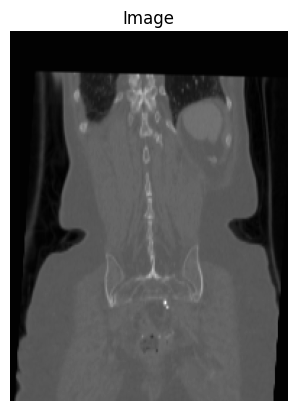

In [10]:
imgIdx = 0
imgSlice = 40

print('imgPath', './data/AbdomenCTCT' + train_images[imgIdx]['image'].removeprefix('.'))

sampleImg = nib.load('./data/AbdomenCTCT' + train_images[imgIdx]['image'].removeprefix('.'))

sampleImg = sampleImg.get_fdata()
print('min', np.min(sampleImg))
print('max', np.max(sampleImg))
print('stride', sampleImg.copy().strides)
sampleImg = (sampleImg - -1024.0) / (1807.9753 - -1024.0)
print('min after norm', np.min(sampleImg))
print('max after norm', np.max(sampleImg))
sampleImg = np.rot90(sampleImg, k=1, axes=(0, 2))
sampleImg = np.swapaxes(sampleImg, 1, 2)
sampleImg = torch.from_numpy(sampleImg.copy())

print(sampleImg.shape)

plt.imshow(sampleImg.detach().cpu().numpy()[:, :, imgSlice], cmap='gray')
plt.title("Image")
plt.axis("off")

 Train

In [11]:
class Logger(object):
    def __init__(self, save_dir):
        self.terminal = sys.stdout
        self.log = open(save_dir + "logfile.log", "a")

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)

    def flush(self):
        pass


def comput_fig(img):
    img = img.detach().cpu().numpy()[0, 0, 48:64, :, :]
    fig = plt.figure(figsize=(12, 12), dpi=180)
    for i in range(img.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.axis('off')
        plt.imshow(img[i, :, :], cmap='gray')
    fig.subplots_adjust(wspace=0, hspace=0)
    return fig


def adjust_learning_rate(optimizer, epoch, MAX_EPOCHES, INIT_LR, power=0.9):
    for param_group in optimizer.param_groups:
        param_group['lr'] = round(INIT_LR * np.power(1 - (epoch) / MAX_EPOCHES, power), 8)


def mk_grid_img(grid_step, line_thickness=1, grid_sz=(256, 192, 160)):
    grid_img = np.zeros(grid_sz)
    for j in range(0, grid_img.shape[1], grid_step):
        grid_img[:, j + line_thickness - 1, :] = 1
    for i in range(0, grid_img.shape[2], grid_step):
        grid_img[:, :, i + line_thickness - 1] = 1
    grid_img = grid_img[None, None, ...]
    grid_img = torch.from_numpy(grid_img).cuda()
    return grid_img


def save_checkpoint(state, save_dir='models', filename='checkpoint.pth.tar', max_model_num=4):
    torch.save(state, save_dir + filename)
    model_lists = natsorted(glob.glob(save_dir + '*'))
    while len(model_lists) > max_model_num:
        os.remove(model_lists[-1])
        model_lists = natsorted(glob.glob(save_dir + '*'))

In [12]:
batch_size = 1
weights = [1, 1]  # loss weights
train_dir = './data/AbdomenCTCT/train'
data_base_dir = './data/AbdomenCTCT'
save_dir = 'VoxelMorph_ncc_{}_diffusion_{}/'.format(weights[0], weights[1])
if not os.path.exists('./data/AbdomenCTCT/experiments/' + save_dir):
    os.makedirs('./data/AbdomenCTCT/experiments/' + save_dir)
if not os.path.exists('./data/AbdomenCTCT/logs/' + save_dir):
    os.makedirs('./data/AbdomenCTCT/logs/' + save_dir)
sys.stdout = Logger('./data/AbdomenCTCT/logs/' + save_dir)
lr = 0.01  #learning rate
epoch_start = 0
max_epoch = 30  #max traning epoch
cont_training = False  #if continue training
model_dir = data_base_dir + '/experiments/' + save_dir

'''
Initialize model
'''
H, W, D = 256, 192, 160
model = VxmDense_2((H, W, D))
model.cuda()

'''
Initialize spatial transformation function
'''
reg_model = register_model((H, W, D))
reg_model.cuda()

'''
If continue from previous training
'''
if cont_training:
    epoch_start = 85
    updated_lr = round(lr * np.power(1 - (epoch_start) / max_epoch, 0.9), 8)
    best_model = torch.load(model_dir + natsorted(os.listdir(model_dir))[0])['state_dict']
    print('Model: {} loaded!'.format(natsorted(os.listdir(model_dir))[0]))
    model.load_state_dict(best_model)
else:
    updated_lr = lr

'''
Initialize training
'''
train_set = AbdomenCTDataset(base_dir=data_base_dir, image_paths=train_images, stage='train')
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=updated_lr, weight_decay=0, amsgrad=True)
if cont_training:
    opt_state = torch.load(model_dir + natsorted(os.listdir(model_dir))[0])['optimizer']
    optimizer.load_state_dict(opt_state)
    print('Optimizer loaded!')

criterion_ncc = NCC_vxm()
criterion_reg = Grad3d(penalty='l2')
writer = SummaryWriter(log_dir=model_dir + '/logs/' + save_dir)

F:\git\CV\MedicalImageRegistration\.venv\Lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Training

In [13]:
epoch_losses = []

for epoch in range(epoch_start, max_epoch):
    print('Training Starts')
    '''
    Training
    '''
    loss_all = AverageMeter()
    idx = 0
    for data in train_loader:
        idx += 1
        model.train()
        adjust_learning_rate(optimizer, epoch, max_epoch, lr)
        with torch.no_grad():
            x = data[0].cuda()
            y = data[1].cuda()
        net_in = torch.cat((x, y), dim=1)
        output, flow = model(net_in)
        loss_ncc = criterion_ncc(output, y) * weights[0]
        loss_reg = criterion_reg(flow, y) * weights[1]
        loss = loss_ncc + loss_reg
        loss_all.update(loss.item(), y.numel())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        net_in = torch.cat((y, x), dim=1)
        output, flow = model(net_in)
        loss_ncc = criterion_ncc(output, x) * weights[0]
        loss_reg = criterion_reg(flow, x) * weights[1]
        loss = loss_ncc + loss_reg
        loss_all.update(loss.item(), x.numel())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Iter {} of {} loss {:.4f}, Img Sim: {:.6f}, Reg: {:.6f}'.format(idx, len(train_loader),
                                                                               loss.item(),
                                                                               loss_ncc.item(),
                                                                               loss_reg.item()))

    # Log the average loss for the epoch
    epoch_loss = loss_all.avg
    epoch_losses.append(epoch_loss)
    writer.add_scalar('Loss/train', loss_all.avg, epoch)
    print('Epoch {} loss {:.4f}'.format(epoch, loss_all.avg))

    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, save_dir=data_base_dir + '/experiments/' + save_dir, filename='voxelmorph_wts.pth.tar')

    grid_img = mk_grid_img(8, 1)
    def_grid = reg_model((grid_img.float(), flow.cuda()))
    plt.switch_backend('agg')
    pred_fig = comput_fig(output)
    grid_fig = comput_fig(def_grid)
    x_fig = comput_fig(x)
    tar_fig = comput_fig(y)
    writer.add_figure('Grid', grid_fig, epoch)
    plt.close(grid_fig)
    writer.add_figure('moving', x_fig, epoch)
    plt.close(x_fig)
    writer.add_figure('fixed', tar_fig, epoch)
    plt.close(tar_fig)
    writer.add_figure('deformed', pred_fig, epoch)
    plt.close(pred_fig)
    loss_all.reset()
writer.close()

KeyboardInterrupt: 

In [ ]:
# Plot the training loss
plt.figure()
plt.plot(range(epoch_start, max_epoch), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

### Model Eval

In [13]:
model_path = './data/AbdomenCTCT/experiments/VoxelMorph_ncc_1_diffusion_1/voxelmorph_wts.pth.tar'
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['state_dict'])
model.cuda()

C:\Users\Tilmann\AppData\Local\Temp\ipykernel_1448\2427114131.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


VxmDense_2(
  (unet_model): Unet(
    (upsample): Upsample(scale_factor=2.0, mode='nearest')
    (downarm): ModuleList(
      (0): ConvBlock(
        (main): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): ConvBlock(
        (main): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (2-3): 2 x ConvBlock(
        (main): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
    )
    (uparm): ModuleList(
      (0): ConvBlock(
        (main): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1-2): 2 x ConvBlock(
        (main): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (activation): LeakyReLU(n

In [14]:
val_set = AbdomenCTDataset(base_dir=data_base_dir, image_paths=val_images, stage='train')
val_loader = DataLoader(val_set, batch_size=1, shuffle=True)

In [15]:
moving_imgs = []
fixed_imgs = []
predicted_outputs = []
predicted_flows = []

with torch.no_grad():
    for i, data in enumerate(val_loader):
        model.eval()
        x = data[0].cuda()
        y = data[1].cuda()
        moving_imgs.append(x)
        fixed_imgs.append(y)
        net_in = torch.cat((x, y), dim=1)
        output, flow = model(net_in)
        predicted_outputs.append(output)
        predicted_flows.append(flow)


In [16]:
len(moving_imgs)

4

In [18]:
valIdx = 2

In [19]:
moving_image_np = moving_imgs[valIdx].cpu().numpy()[0, 0, :, :,
                  int(moving_imgs[valIdx].shape[4] / 2)]  # Get a central slice
fixed_image_np = fixed_imgs[valIdx].cpu().numpy()[0, 0, :, :,
                 int(fixed_imgs[valIdx].shape[4] / 2)]  # Get a central slice
predicted_output_np = predicted_outputs[valIdx].cpu().numpy()[0, 0, :, :,
                      int(predicted_outputs[valIdx].shape[4] / 2)]  # Get a central slice
predicted_flow_np = predicted_flows[valIdx].cpu().numpy()[0, 0, :, :,
                    int(predicted_flows[valIdx].shape[4] / 2)]  # Get a central slice

(-0.5, 191.5, 255.5, -0.5)

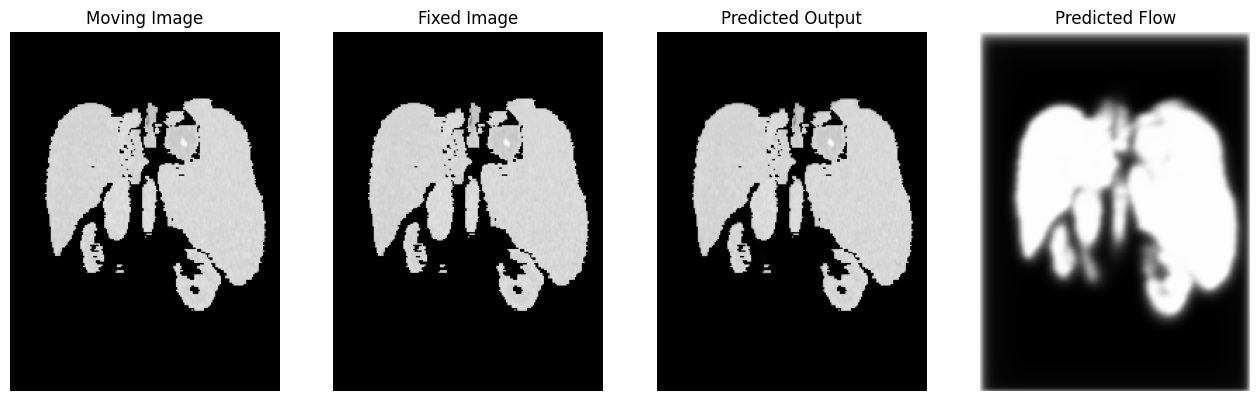

In [23]:
# Step 4: Plot the images side by side

fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(16,8))
# Plot moving image
ax0.imshow(moving_image_np, cmap='gray')
ax0.set_title('Moving Image')
ax0.axis('off')

# Plot fixed image
ax1.imshow(fixed_image_np, cmap='gray')
ax1.set_title('Fixed Image')
ax1.axis('off')

# Plot predicted output image
ax2.imshow(predicted_output_np, cmap='gray')
ax2.set_title('Predicted Output')
ax2.axis('off')

# Plot predicted flow image
ax3.imshow(predicted_flow_np, cmap='gray')
ax3.set_title('Predicted Flow')
ax3.axis('off')
